### __Identifying Appropiate Method for Avoiding Rescraping/Reprocessing Pages - lse_crawler__

In [2]:
import requests
import hashlib

url = "https://coinmarketcap.com/"

response = requests.get(url)
content = response.text

# Create a hash of the content
content_hash = hashlib.md5(content.encode()).hexdigest()

print(f"Content hash: {content_hash}")



Content hash: 298d0b2ae1c2716360e436a375b58c09


I waited one minute in between these two requests and got a different hash. This is expected as the page constantly updates itself.

In [31]:
url = "https://coinmarketcap.com/"

response = requests.get(url)
content = response.text

# Create a hash of the content
content_hash = hashlib.md5(content.encode()).hexdigest()

print(f"Content hash: {content_hash}")

Content hash: 1bc289d39e2e1425782cf6229523d791


Below is a similar experiment for a weather website, which is constantly updating itself.

In [36]:
import time

url = "https://weather.com/en-GB/weather/hourbyhour/l/82ce477283f4943abb3e6b33ab0958d41e2ae224b2429d8b7decd8fb42e2493f"
response = requests.get(url)
content = response.text
content_hash = hashlib.md5(content.encode()).hexdigest()
print(f"Content hash: {content_hash}")

time.sleep(5)
url_2 = "https://weather.com/en-GB/weather/hourbyhour/l/82ce477283f4943abb3e6b33ab0958d41e2ae224b2429d8b7decd8fb42e2493f"
response_2 = requests.get(url)
content_2 = response_2.text
content_hash_2 = hashlib.md5(content_2.encode()).hexdigest()
print(f"Content_2 hash: {content_hash_2}")


Content hash: 7ea86a5b8c64eb61d45b5bfcea46807f
Content_2 hash: 2a588be8a4a7bf8ca5a362af362fd99e


Conclusion:
- When the content of a page has changed, and required the page to be reloaded, the hash will change.
- When the content of a page has changed, but does not require the page to be reloaded, the hash will not change.

Checking whether the hash has changed is not could be used to determine whether the page has changed.


### Testing out the hash on current html of lse_crawler output

In [3]:
#open the jl file 
import json
import hashlib
import time
import os
dictionary = os.open('/Users/jamie/Desktop/chatlse2024/chat-lse/crawler/data/boxes.jl', os.O_RDWR)

#read the file
data = os.read(dictionary, 1000000)

#get the entry from the html key of the first dictionary entry
entry = json.loads(data.decode().split("\n")[0])
print(entry['html'], entry['current_hash'])

<div class="component__details">
                	<h2 class="component__title"><span class="default">Embedding data science at LSE</span> Professor Ken Benoit, Baroness Minouche Shafik, and Professor Susana Mourato introduce the DSI</h2>
                                                            	</div> 5645ede2a1afc0a9e819142559afd067


In [5]:
#copy the html and alter by a few characters, to see if the hash indeed changes
html = entry['html']
html = html.replace("component__title", "replaced__title")
print(html)

#hash the html
html_hash = hashlib.md5(html.encode()).hexdigest()
print(html_hash)

<div class="component__details">
                	<h2 class="replaced__title"><span class="default">Embedding data science at LSE</span> Professor Ken Benoit, Baroness Minouche Shafik, and Professor Susana Mourato introduce the DSI</h2>
                                                            	</div>
769ac7d9639abc931e5e2ebbf9fa4d04


As we can see, by simple changing one word within the html, the hash changes. Therefore, we can reliably use the hash to determine whether the page has changed.


### Testing the lse_crawler update

First we must clear all history to the lse_crawler. Then we will run the lse_crawler

In [13]:
import sqlite3



conn = sqlite3.connect('/Users/jamie/Desktop/chatlse2024/chat-lse/crawler/data/dsi_crawler.db')
cursor = conn.cursor()

# Drop tables
cursor.execute('DROP TABLE IF EXISTS Webpage')
cursor.execute('DROP TABLE IF EXISTS Box')
cursor.execute('DROP TABLE IF EXISTS CrawlerMetadata')
cursor.execute('DROP TABLE IF EXISTS Links')

conn.commit()
conn.close()


In [14]:
import os

files_to_remove = ['data/pages.jl', 'data/boxes.jl']

for file_path in files_to_remove:
    if os.path.exists(file_path):
        os.remove(file_path)



Rerunning the lse_crawler. 
- Within the settings.py file, change LOG_LEVEL to 'INFO' to see the logs of the pipeline.
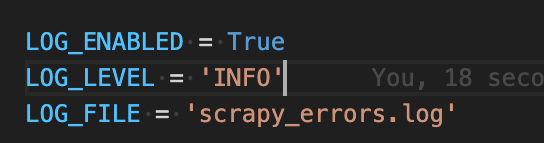
- run the lse_crawler in terminal using:
```
scrapy crawl lse_crawler --loglevel=INFO
```

### Main Changes to pipeline.py

- Split the process_item function into two functions: process_box and process_page. I found this to be helpful for efficiency to prevent several unesssary loops when the item can already be classified as a box or a page before checking the existence of the hash.
- Added a check to see if the current hash is the same as the previous hash. If it is, then the page has not changed and the item is dropped. If it is different, then the page has changed and the item is processed.

#### Changes to the items.py and lse_crawler.py
- Added a current_hash field to the items.py file to store the hash of the page.
- Added a function to the lse_crawler.py file to calculate the hash of the page.

#### Exploring the database; 1st Attempt

In [12]:
import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect('/Users/jamie/Desktop/chatlse2024/chat-lse/crawler/data/dsi_crawler.db')
cursor = conn.cursor()

# Query to find duplicate htmls in the Webpage table
query = '''
SELECT html, COUNT(*)
FROM Box
GROUP BY html
HAVING COUNT(*) > 1;
'''

# Execute the query
cursor.execute(query)

# Fetch and print the results
duplicates = cursor.fetchall()
print("Duplicate URLs:")
for row in duplicates:
    print(f"Duplicate html, Count: {row[1]}")

# Query to find duplicate URLs and current_hash combinations in the Webpage table
query = '''
SELECT url, current_hash, COUNT(*)
FROM Box
GROUP BY url, current_hash
HAVING COUNT(*) > 1;
'''

# Execute the query
cursor.execute(query)

# Fetch and print the results
duplicates = cursor.fetchall()
print("Duplicate URL and current_hash combinations:")
for row in duplicates:
    print(f"URL: {row[0]}, current_hash: {row[1]}, Count: {row[2]}")

# Close the connection
conn.close()


Duplicate URLs:
Duplicate html, Count: 2
Duplicate html, Count: 4
Duplicate html, Count: 4
Duplicate html, Count: 4
Duplicate html, Count: 2
Duplicate html, Count: 4
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 6
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 4
Duplicate html, Count: 3
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 8
Duplicate html, Count: 12
Duplicate html, Count: 2
Duplicat

This indicates that the function may be inserting rather than updating the rows in the database. We need to ensure every entry is unique.

#### 2nd Attempt

In [15]:
import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect('/Users/jamie/Desktop/chatlse2024/chat-lse/crawler/data/dsi_crawler.db')
cursor = conn.cursor()

# Query to find duplicate htmls in the Webpage table
query = '''
SELECT html, COUNT(*)
FROM Box
GROUP BY html
HAVING COUNT(*) > 1;
'''

# Execute the query
cursor.execute(query)

# Fetch and print the results
duplicates = cursor.fetchall()
print("Duplicate URLs:")
for row in duplicates:
    print(f"Duplicate html, Count: {row[1]}")

# Query to find duplicate URLs and current_hash combinations in the Webpage table
query = '''
SELECT url, current_hash, COUNT(*)
FROM Box
GROUP BY url, current_hash
HAVING COUNT(*) > 1;
'''

# Execute the query
cursor.execute(query)

# Fetch and print the results
duplicates = cursor.fetchall()
print("Duplicate URL and current_hash combinations:")
for row in duplicates:
    print(f"URL: {row[0]}, current_hash: {row[1]}, Count: {row[2]}")

# Close the connection
conn.close()


Duplicate URLs:
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 3
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 3
Duplicate html, Count: 2
Duplicate html, Count: 3
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 3
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate html, Count: 2
Duplicate

Though there are still some instances of duplicate htmls, there are significantly fewer than before. This is a good sign that the function is working as intended.

Moreover, there are now no duplicate url and current_hash pairs, implying that no duplicate pages are being inserted into the database.